In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import export_graphviz, plot_tree
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from treeinterpreter import treeinterpreter
# from fastai.tabular import *
sns.set()

d:\hust\support_system\project\dss\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# EDA

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [11]:
df_raw = pd.read_csv('churn2.csv')
display_all(df_raw.head())

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [6]:
df_raw.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [7]:
numerics = ['number vmail messages', 'account length', 'total day minutes', 'total day calls', 'total day charge','total eve minutes',
            'total eve calls', 'total eve charge','total night minutes', 'total night calls', 'total night charge',
            'total intl minutes', 'total intl calls', 'total intl charge','customer service calls']
categories = ['state', 'area code', 'international plan', 'voice mail plan'] 

In [11]:
df_raw.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [14]:
df_raw.describe(include=['object', 'bool'])

,state,phone number,international plan,voice mail plan,churn
count,3333,3333,3333,3333,3333
unique,51,3333,2,2,2
top,WV,376-5213,no,no,False
freq,106,1,3010,2411,2850


In [36]:
df_raw['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

In [38]:
df_raw['area code'].unique()

array([415, 408, 510])

In [47]:
df_raw['international plan'].value_counts(normalize=True)

no     0.90309
yes    0.09691
Name: international plan, dtype: float64

In [48]:
df_raw['voice mail plan'].value_counts(normalize=True)

no     0.723372
yes    0.276628
Name: voice mail plan, dtype: float64

In [51]:
df_raw['total charge'] = df_raw.loc[:, ['total day charge', 'total eve charge',
                                        'total night charge', 'total intl charge']].sum(axis=1)

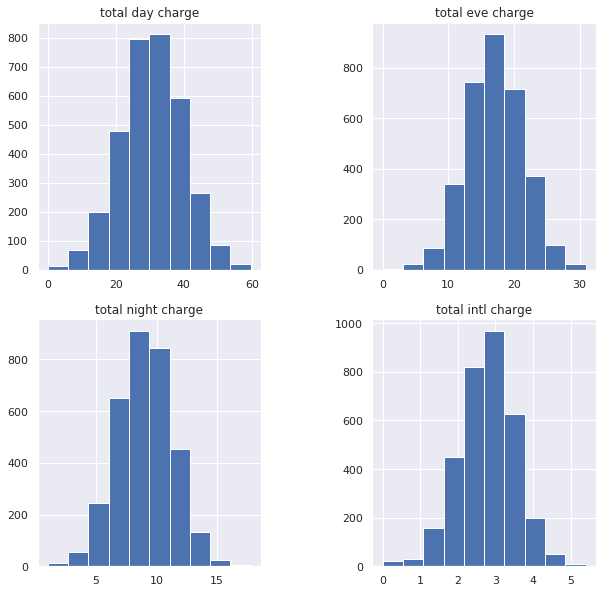

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.5)
col = np.array(['total day charge', 'total eve charge', 'total night charge', 'total intl charge']).reshape(2, 2)
for i in range(2):
    for j in range(2):
        ax[i, j].hist(df_raw[col[i, j]])
        ax[i, j].set_title(col[i, j])

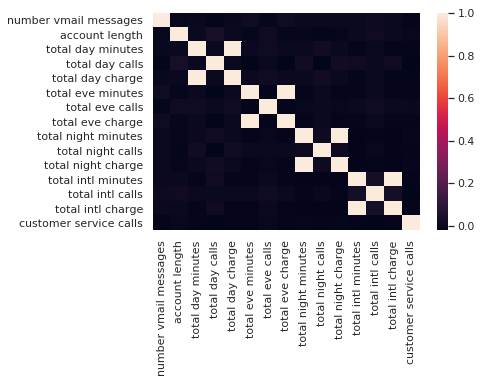

In [20]:
cor = df_raw[numerics].corr()
sns.heatmap(cor)

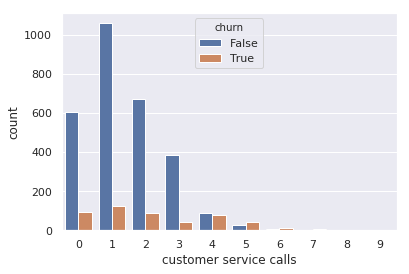

In [21]:
fig, ax = plt.subplots()
sns.countplot(df_raw['customer service calls'], hue='churn', data=df_raw)

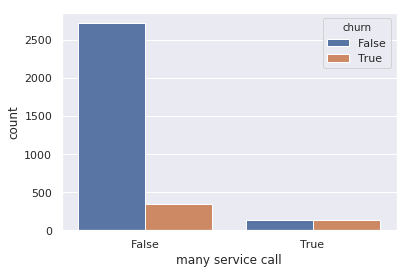

In [24]:
df_raw['many service call'] = df_raw['customer service calls'] >= 4
sns.countplot('many service call', hue='churn', data=df_raw)

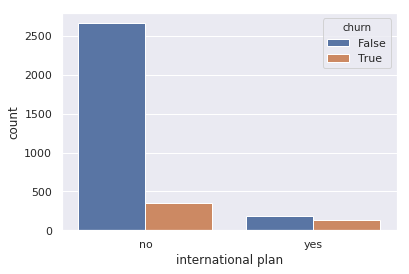

In [25]:
sns.countplot('international plan', hue='churn', data=df_raw)

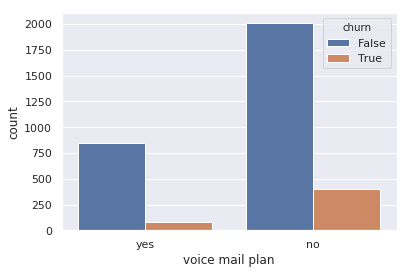

In [26]:
sns.countplot('voice mail plan', hue='churn', data=df_raw)

In [27]:
df_raw.groupby('churn')['total day charge', 'total eve charge', 'total night charge', 'total intl charge'].mean()

,total day charge,total eve charge,total night charge,total intl charge
churn,,,,
False,29.780421,16.918909,9.006074,2.743404
True,35.175921,18.054969,9.235528,2.889545


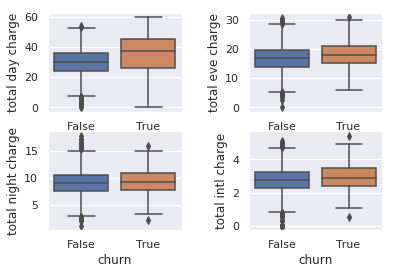

In [9]:
fig, ax = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i, col in enumerate(['total day charge', 'total eve charge', 'total night charge', 'total intl charge']):
    sns.boxplot(x='churn', y=col, data=df_raw, ax=ax[i//2, i%2])

## Note
- Chares are completely calculated from minutes
- Churn users have on average higher 

In [13]:
df_raw = pd.read_csv('churn2.csv')

In [14]:
df_raw.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [15]:
df_raw['many service call'] = df_raw['customer service calls'] >= 4
y = df_raw['churn']
df_raw.drop(['churn', 'phone number'], axis=1, inplace=True)

In [16]:
class DFProc():
    def __call__(self, df, test=False):
        func = self.apply_test if test else self.apply_train
        return func(df)
    def apply_train(self, df):
        raise NotImplementedError
    def apply_test(self, df):
        self.apply_train(df)
        
class ProcCategory(DFProc):
    def __init__(self, cat_names):
        self.cat_names = cat_names
        self.categories = {}
        
    def apply_train(self, df):
        for i in self.cat_names:
            df.loc[:, i] = df.loc[:, i].astype('category').cat.as_ordered()
            self.categories[i] = df.loc[:, i].cat.categories
            df[i] = df[i].cat.codes
        return df   
    def apply_test(self, df):
        for i in self.cat_names:
            df[i] = pd.Categorical(df[i], categories=self.categories[i])
            df[i] = df[i].cat.codes
        return df
    
class Normalize(DFProc):
    def __init__(self, cont_vars):
        self.cont_vars = cont_vars
        self.means = {}
        self.stds = {}
    
    def apply_train(self, df):
        for c in self.cont_vars:
            self.means[c] = df.loc[:, c].mean()
            self.stds[c] = df.loc[:, c].std()
            df.loc[:, c] = (df.loc[:, c] - self.means[c]) / (1e-7 + self.stds[c])
        return df
    
    def apply_test(self, df):
        for c in self.cont_vars:
            df.loc[:, c] = (df.loc[:, c] - self.means[c]) / (1e-7 + self.stds[c])
        return df

In [17]:
df_raw.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'many service call'],
      dtype='object')

In [18]:
cat_var = ['state', 'area code', 'international plan', 'voice mail plan', 'many service call']
num_var = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge',
           'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls',
           'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']

proc = ProcCategory(cat_var)

In [19]:
df = proc(df_raw)

In [20]:
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,many service call
0,16,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,1,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,0,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,1,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


# Baseline Random Forest

In [21]:
train_idx = np.load('train_idx.npy')
valid_idx = np.load('valid_idx.npy')
keep_cols = np.load('keep_cols.npy', allow_pickle=True)

In [23]:
def print_score(m):
    y_train_pred = m.predict(X_train)
    y_valid_pred = m.predict(X_valid)
    print('Train accuracy ', m.score(X_train, y_train))
    print('Train precision ', precision_score(y_train, y_train_pred))
    print('Train recall ', recall_score(y_train, y_train_pred))
    print('Train f1 score ', f1_score(y_train, y_train_pred))
    print('Validation accuracy ', m.score(X_valid, y_valid))
    print('Validation precision ', precision_score(y_valid, y_valid_pred))
    print('validation recall ', recall_score(y_valid, y_valid_pred))
    print('Validation f1 score ', f1_score(y_valid, y_valid_pred))
    if hasattr(m, 'oob_score_'): print('oob score ', m.oob_score_)

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.18, stratify=y, random_state=10)

In [24]:
X_train, X_valid, y_train, y_valid = df.iloc[train_idx], df.iloc[valid_idx], y[train_idx], y[valid_idx]

In [15]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2733, 20), (2733,), (600, 20), (600,))

In [125]:
rf = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [126]:
print_score(rf) #baseline

Train accuracy  0.9769484083424808
Train precision  0.9882697947214076
Train recall  0.851010101010101
Validation accuracy  0.955
Validation precision  0.8846153846153846
validation recall  0.7931034482758621
oob score  0.955360409806074


In [22]:
rf = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print_score(rf)

Train accuracy  0.9780461031833151
Train precision  0.9941176470588236
Train recall  0.8535353535353535
Train f1 score  0.9184782608695652
Validation accuracy  0.9533333333333334
Validation precision  0.8831168831168831
validation recall  0.7816091954022989
Validation f1 score  0.8292682926829268
oob score  0.9531650201244054


# Interpretation

In [21]:
preds = np.stack([t.predict(X_valid.reset_index(drop=True)) for t in rf.estimators_])
np.std(preds[:, 5])

0.0

In [22]:
x = X_valid.reset_index(drop=True).copy()
x['pred'] = np.mean(preds, axis=0)
x['pred_std'] = np.std(preds, axis=0)
x['churn'] = y_valid

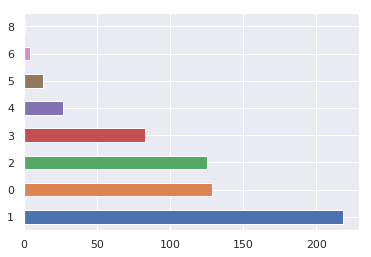

In [19]:
x['customer service calls'].value_counts().plot.barh()

In [20]:
field = ['customer service calls', 'international plan', 'churn', 'pred', 'pred_std']
call = x[field].groupby('customer service calls').mean()
call

,international plan,pred,pred_std
customer service calls,,,
0,0.093023,0.113023,0.178911
1,0.091743,0.097431,0.164307
2,0.048000,0.091200,0.166661
3,0.120482,0.116386,0.164770
4,0.000000,0.554074,0.294542
5,0.076923,0.603846,0.315306
6,0.000000,0.545000,0.213949
8,0.000000,0.020000,0.140000


<BarContainer object of 8 artists>

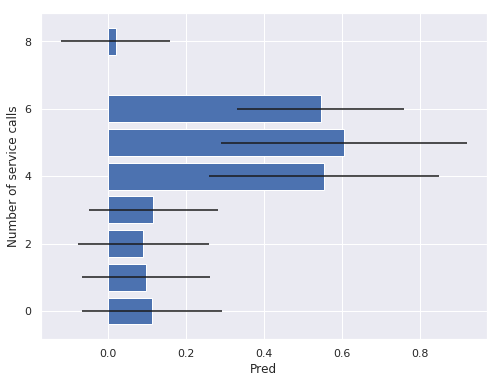

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Pred')
ax.set_ylabel('Number of service calls')
ax.barh(call.index, call['pred'], xerr=call['pred_std'])

In [22]:
call['pred_std'].sort_values(ascending=False)

customer service calls
5    0.315306
4    0.294542
6    0.213949
0    0.178911
2    0.166661
3    0.164770
1    0.164307
8    0.140000
Name: pred_std, dtype: float64

<BarContainer object of 2 artists>

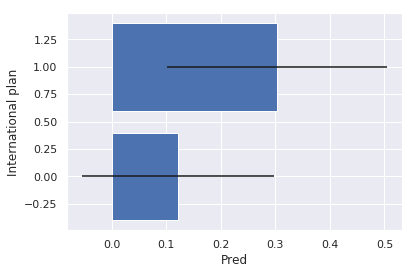

In [23]:
intl = x[field].groupby('international plan', as_index=False).mean()
fig, ax = plt.subplots()
ax.set_xlabel('Pred')
ax.set_ylabel('International plan')
ax.barh(intl['international plan'], intl['pred'], xerr=intl['pred_std'])


# Feature importance

In [23]:
def plot_imp(imp): 
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(imp['Feature'], imp['Importance'])

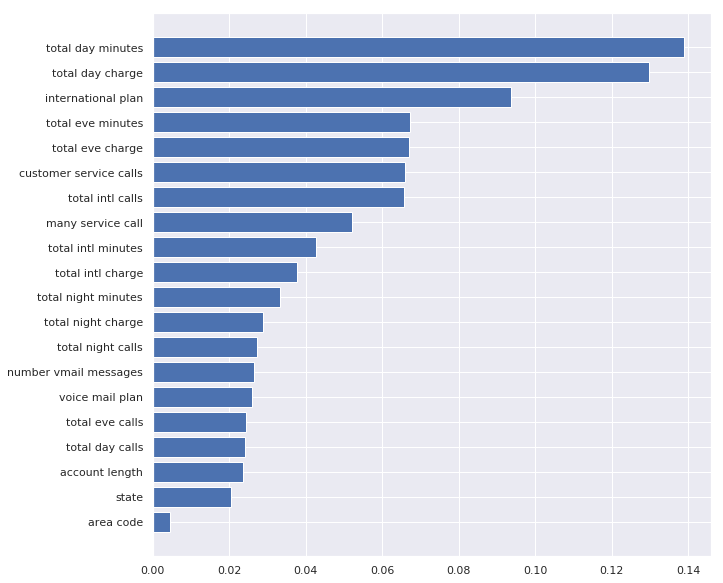

In [128]:
imp = pd.DataFrame({'Feature': df.columns, 'Importance': rf.feature_importances_}).sort_values('Importance')
plot_imp(imp)

In [129]:
keep = imp[imp['Importance'] > 0.03].Feature
len(keep)

11

In [132]:
df_keep = X_train[keep].copy()
m = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                            n_jobs=-1, oob_score=True)
m.fit(df_keep, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [133]:
m.score( X_valid[keep], y_valid), m.score(df_keep, y_train), recall_score(y_train, m.predict(df_keep)), recall_score(y_valid, m.predict(X_valid[keep]), y_valid)

(0.9433333333333334,
 0.9718258324185877,
 0.8333333333333334,
 0.7586206896551724)

In [134]:
per_imp = PermutationImportance(rf).fit(X_valid, y_valid)

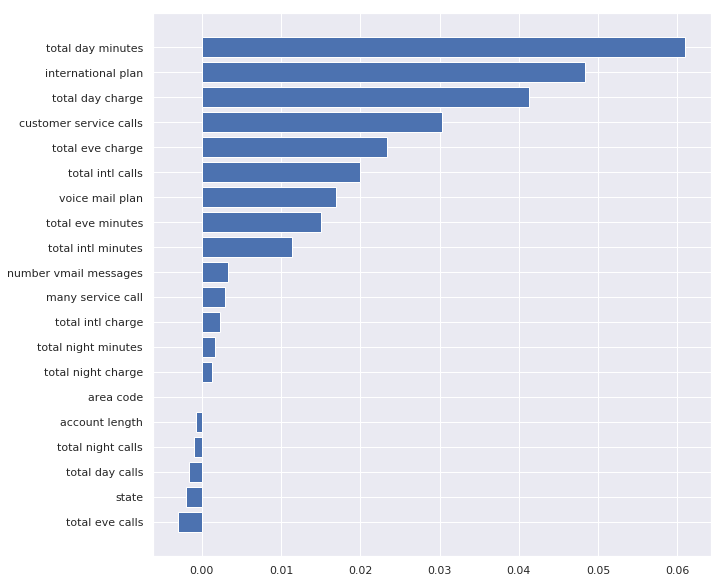

In [135]:
per_imp = pd.DataFrame({'Feature': df.columns, 'Importance': per_imp.feature_importances_}).sort_values('Importance')
plot_imp(per_imp)

In [75]:
from eli5.permutation_importance import get_score_importances

In [136]:
def score(X, y):
    y_pred = rf.predict(X)
    return recall_score(y, y_pred)

imp = get_score_importances(score, X_valid.values, y_valid.values)

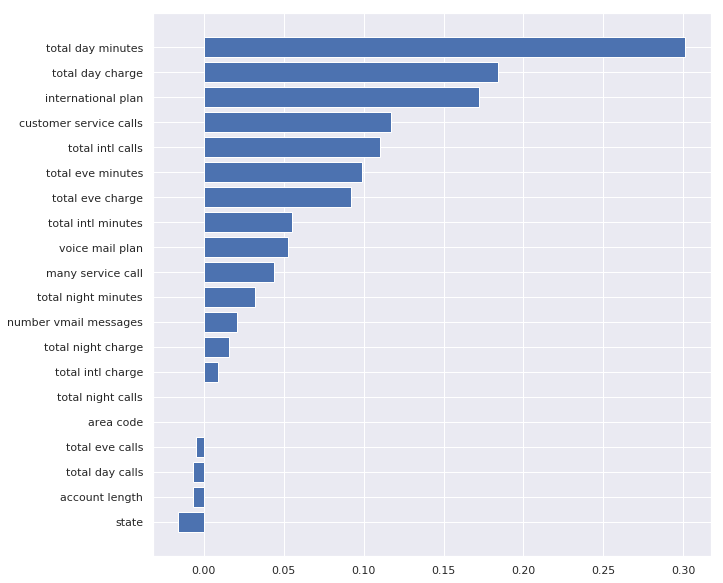

In [137]:
recall_drop_imp = pd.DataFrame({'Feature': df.columns, 'Importance': np.array(imp[1]).mean(axis=0)}).sort_values('Importance')
plot_imp(recall_drop_imp)

In [140]:
keep_cols = recall_drop_imp[recall_drop_imp['Importance'] > 0.005].Feature.values

In [142]:
X_train, X_valid, y_train, y_valid = train_test_split(df.loc[:, keep_cols], y, test_size=0.18, stratify=y, random_state=101)

In [145]:
X_train, X_valid, y_train, y_valid = df.iloc[train_idx][keep_cols], df.iloc[valid_idx][keep_cols], y[train_idx], y[valid_idx]

In [236]:
rf = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [237]:
print_score(rf)

Train accuracy  0.9762166117819246
Train precision  0.9910979228486647
Train recall  0.8434343434343434
Validation accuracy  0.96
Validation precision  0.8888888888888888
validation recall  0.8275862068965517
oob score  0.9520673252835712


# One-hot encoding

In [80]:
train_idx = np.load('train_idx.npy')
valid_idx = np.load('valid_idx.npy')

In [238]:
df_keep = df[keep_cols]
df_keep.head()

,total intl charge,total night charge,number vmail messages,total night minutes,many service call,voice mail plan,total intl minutes,total eve charge,total eve minutes,total intl calls,customer service calls,international plan,total day charge,total day minutes
0,2.70,11.01,25,244.7,0,1,10.0,16.78,197.4,3,1,0,45.07,265.1
1,3.70,11.45,26,254.4,0,1,13.7,16.62,195.5,3,1,0,27.47,161.6
2,3.29,7.32,0,162.6,0,0,12.2,10.30,121.2,5,0,0,41.38,243.4
3,1.78,8.86,0,196.9,0,0,6.6,5.26,61.9,7,2,1,50.90,299.4
4,2.73,8.41,0,186.9,0,0,10.1,12.61,148.3,3,3,1,28.34,166.7


In [239]:
dummies_col = ['international plan',  'many service call', 'voice mail plan']
prefix = {'international plan':'international',  'many service call':'many_call', 'voice mail plan':'vmail'}
df_enc = pd.get_dummies(df_keep, prefix=prefix, columns=dummies_col)

In [240]:
X_train, X_valid, y_train, y_valid = df_enc.iloc[train_idx], df_enc.iloc[valid_idx], y[train_idx], y[valid_idx]

In [265]:
rf = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print_score(rf)

Train accuracy  0.9754848152213684
Train precision  0.991044776119403
Train recall  0.8383838383838383
Validation accuracy  0.9583333333333334
Validation precision  0.8875
validation recall  0.8160919540229885
oob score  0.9549945115257958


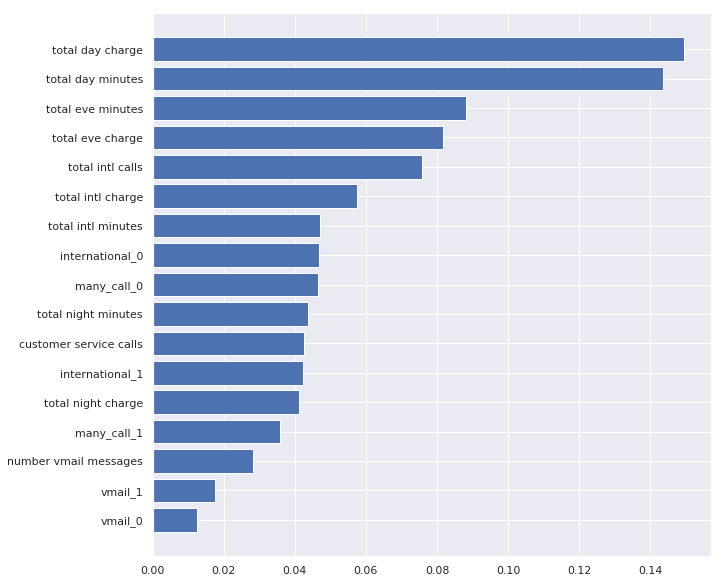

In [243]:
imp = pd.DataFrame({'Feature': df_enc.columns, 'Importance': rf.feature_importances_}).sort_values('Importance')
plot_imp(imp)

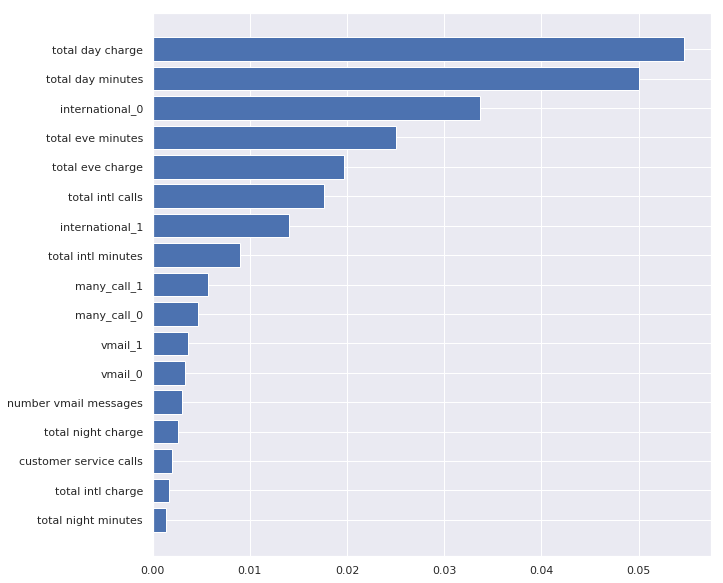

In [266]:
per_imp = PermutationImportance(rf).fit(X_valid, y_valid)
per_imp = pd.DataFrame({'Feature': df_enc.columns, 'Importance': per_imp.feature_importances_}).sort_values('Importance')
plot_imp(per_imp)

# Remove redundant feature

In [267]:
from scipy.cluster import hierarchy as hc

In [25]:
X_train, X_valid, y_train, y_valid = df.iloc[train_idx][keep_cols], df.iloc[valid_idx][keep_cols], y[train_idx], y[valid_idx]

In [269]:
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr

array([[ 1.00e+00,  3.00e-03,  1.53e-02, -4.70e-03, ...,  1.18e-02, -4.60e-03, -2.10e-02, -2.80e-02],
       [ 3.00e-03,  1.00e+00, -1.74e-02,  2.95e-02, ...,  2.75e-02,  1.48e-02, -5.90e-03,  9.60e-03],
       [ 1.53e-02, -1.74e-02,  1.00e+00,  4.40e-02, ..., -5.20e-03,  3.20e-03,  3.19e-02,  7.50e-03],
       [-4.70e-03,  2.95e-02,  4.40e-02,  1.00e+00, ...,  8.00e-03,  4.38e-02, -3.03e-02,  7.90e-03],
       ...,
       [ 1.18e-02,  2.75e-02, -5.20e-03,  8.00e-03, ...,  1.00e+00,  1.79e-02, -6.00e-04, -2.77e-02],
       [-4.60e-03,  1.48e-02,  3.20e-03,  4.38e-02, ...,  1.79e-02,  1.00e+00, -1.74e-02,  2.80e-03],
       [-2.10e-02, -5.90e-03,  3.19e-02, -3.03e-02, ..., -6.00e-04, -1.74e-02,  1.00e+00,  4.87e-01],
       [-2.80e-02,  9.60e-03,  7.50e-03,  7.90e-03, ..., -2.77e-02,  2.80e-03,  4.87e-01,  1.00e+00]])

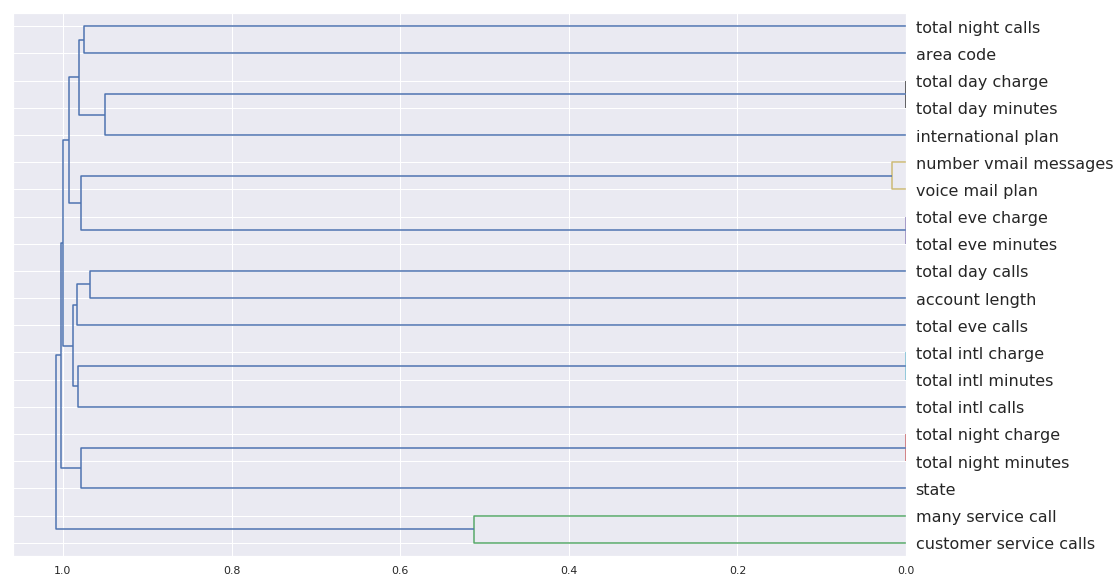

In [270]:
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [86]:
rf = RandomForestClassifier(200, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)

In [272]:
for c in ['total day charge', 'total day minutes', 'number vmail messages', 'voice mail plan',
          'total eve charge', 'total eve minutes', 'total intl charge', 'total intl minutes',
          'total night charge', 'total night minutes']:
    rf = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)
    rf.fit(X_train.drop(c, axis=1), y_train)
    print(c, rf.score(X_valid.drop(c, axis=1), y_valid), 
             recall_score(y_valid, rf.predict(X_valid.drop(c, axis=1))), 
             rf.oob_score_)
    print()

total day charge 0.96 0.8045977011494253 0.9524332235638493

total day minutes 0.96 0.8045977011494253 0.9542627149652396

number vmail messages 0.9583333333333334 0.7931034482758621 0.9535309184046835

voice mail plan 0.9583333333333334 0.7931034482758621 0.9546286132455177

total eve charge 0.955 0.7816091954022989 0.9538968166849616

total eve minutes 0.9583333333333334 0.8045977011494253 0.9549945115257958

total intl charge 0.955 0.7816091954022989 0.9549945115257958

total intl minutes 0.9616666666666667 0.8275862068965517 0.9542627149652396

total night charge 0.95 0.7586206896551724 0.9502378338821807

total night minutes 0.9566666666666667 0.7931034482758621 0.9535309184046835



In [327]:
to_drop = ['total day minutes', 'total eve minutes', 'total intl minutes', 'total night minutes', 'voice mail plan']
rf = RandomForestClassifier(100, criterion='entropy', min_samples_leaf=3, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train.drop(to_drop, axis=1), y_train)
rf.score(X_valid.drop(to_drop, axis=1), y_valid), recall_score(y_valid, rf.predict(X_valid.drop(to_drop, axis=1))), rf.oob_score_

(0.96, 0.8045977011494253, 0.9546286132455177)

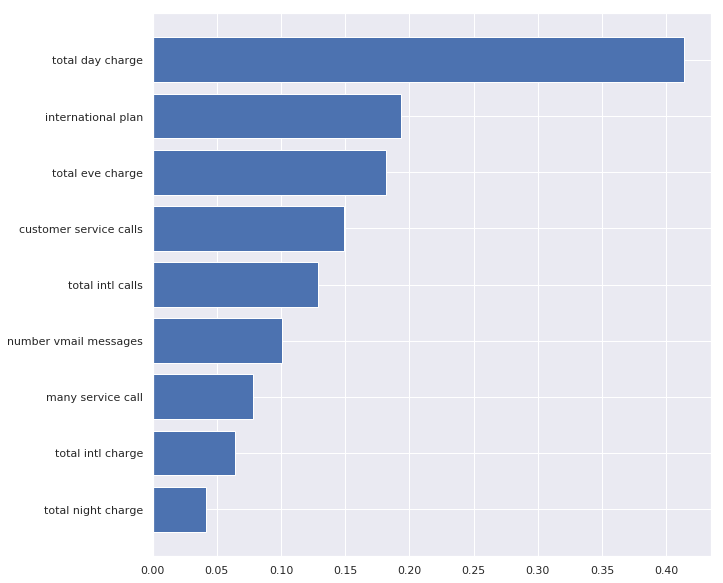

In [328]:
imp = get_score_importances(score, X_valid.drop(to_drop, axis=1).values, y_valid.values)
recall_drop_imp = pd.DataFrame({'Feature': X_train.drop(to_drop, axis=1).columns, 'Importance': np.array(imp[1]).mean(axis=0)}).sort_values('Importance')
plot_imp(recall_drop_imp)

In [329]:
keep_cols = np.array(list(set(keep_cols).difference(set(['total day minutes', 'total eve minutes', 
                               'total intl minutes', 'total night minutes', 'voice mail plan']))))
keep_cols

array(['total intl charge', 'customer service calls', 'many service call', 'total eve charge', 'number vmail messages',
       'international plan', 'total intl calls', 'total night charge', 'total day charge'], dtype='<U22')

In [331]:
len(keep_cols)

9

In [333]:
np.save('keep_cols.npy', keep_cols)

In [26]:
X_train = X_train[keep_cols]
X_valid = X_valid[keep_cols]

In [27]:
weights = {False:0.6, True:3.3}

In [30]:
rf = RandomForestClassifier(1000, criterion='entropy', min_samples_leaf=6, max_features='sqrt',
                             n_jobs=-1, oob_score=True, class_weight=weights)
rf.fit(X_train, y_train)
print_score(rf)

Train accuracy  0.9626783754116356
Train precision  0.875
Train recall  0.8661616161616161
Train f1 score  0.8705583756345178
Validation accuracy  0.95
Validation precision  0.8
validation recall  0.8735632183908046
Validation f1 score  0.8351648351648352
oob score  0.9473106476399561


In [414]:
joblib.dump(rf, 'rf.joblib')

['rf.joblib']

In [12]:
from treeinterpreter import treeinterpreter as ti

In [29]:
rf = joblib.load('rf.joblib')

array([False, False, False, ..., False, False, False])

In [54]:
keep_cols = np.array(['total_intl_charge', 'customer_service_calls', 'many_service_call',
                       'total_eve_charge', 'number_vmail_messages', 'international_plan',
                       'total_intl_calls', 'total_night_charge', 'total_day_charge'])

In [49]:
data = pd.read_csv('churn.csv')

In [50]:
data['many_service_call'] = data['customer_service_calls'] >=4

In [51]:
data.head()

,id,state_name,state,account_length,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,many_service_call
0,1,Kansas,KS,128,(415) 382-4657,No,Yes,25,265.1,110,...,16.78,244.7,91,11.01,10.0,3,2.70,1,False,False
1,2,Ohio,OH,107,(415) 371-7191,No,Yes,26,161.6,123,...,16.62,254.4,103,11.45,13.7,3,3.70,1,False,False
2,3,New Jersey,NJ,137,(415) 358-1921,No,No,0,243.4,114,...,10.30,162.6,104,7.32,12.2,5,3.29,0,False,False
3,4,Ohio,OH,84,(408) 375-9999,Yes,No,0,299.4,71,...,5.26,196.9,89,8.86,6.6,7,1.78,2,False,False
4,5,Oklahoma,OK,75,(415) 330-6626,Yes,No,0,166.7,113,...,12.61,186.9,121,8.41,10.1,3,2.73,3,False,False


In [59]:
cat_var = ['state', 'state_name',  'international_plan', 'voice_mail_plan', 'many_service_call']
# num_var = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge',
#            'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls',
#            'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']

proc = ProcCategory(cat_var)
data = proc(data)

In [77]:
y.mean()

0.14491449144914492

In [64]:
rf.predict_proba(data[keep_cols])[:, 1].shape

(3333,)

In [65]:
data['churn'] = rf.predict(data[keep_cols])
data['churn_pct'] = rf.predict_proba(data[keep_cols])[:, 1]

In [53]:
data.columns

Index(['id', 'state_name', 'state', 'account_length', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn', 'many_service_call'],
      dtype='object')

In [19]:
X_train = X_train[keep_cols]
X_valid = X_valid[keep_cols]

In [22]:
X_valid.iloc[0].values

array([ 3.78,  2.  ,  0.  , 17.66,  0.  ,  0.  ,  2.  ,  9.23, 45.27])

In [26]:
prediction, bias, contributions = ti.predict(rf, X_valid.values[None, 0])

In [44]:
contributions.squeeze()[:, 1]

array([ 0.034077, -0.025641, -0.024435,  0.005134,  0.051881, -0.045087, -0.015079, -0.007052,  0.393   ])

In [45]:
idx = np.argsort(contributions.squeeze()[:, 1], asce)

In [48]:
[o for o in zip(X_valid.columns[idx], X_valid.iloc[0][idx], contributions.squeeze()[:, 1][idx])]

[('international plan', 0.0, -0.04508735846623425),
 ('customer service calls', 2.0, -0.025640820700406575),
 ('many service call', 0.0, -0.02443463950493236),
 ('total intl calls', 2.0, -0.01507897723198912),
 ('total night charge', 9.23, -0.007051985728307157),
 ('total eve charge', 17.66, 0.005133537256819989),
 ('total intl charge', 3.78, 0.03407730224499532),
 ('number vmail messages', 0.0, 0.05188107637787684),
 ('total day charge', 45.27, 0.39299966899620226)]

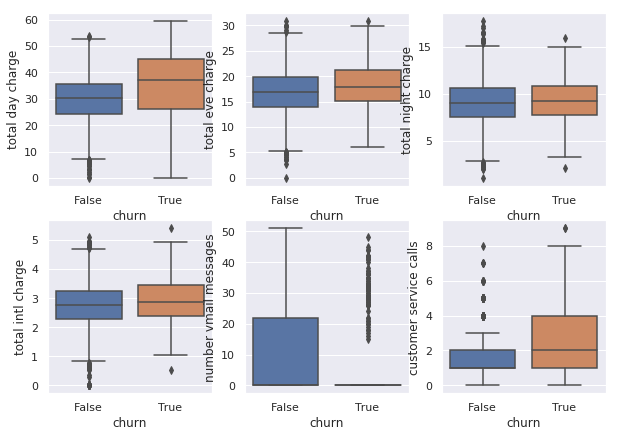

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for i, feat in enumerate(['total day charge', 'total eve charge', 'total night charge', 'total intl charge', 'number vmail messages', 'customer service calls']):
    a = ax[i//3, i%3]
    sns.boxplot(x=y, y=df_raw[feat], ax=a)

# Deep learning

In [12]:
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
pd.options.mode.chained_assignment = None

In [13]:
train_idx = np.load('train_idx.npy')
valid_idx = np.load('valid_idx.npy')
keep_cols = np.load('keep_cols.npy')

In [14]:
df = df_raw[keep_cols]
df.head()

,total night charge,customer service calls,number vmail messages,total intl calls,total intl charge,international plan,total eve charge,many service call,total day charge
0,11.01,1,25,3,2.70,0,16.78,0,45.07
1,11.45,1,26,3,3.70,0,16.62,0,27.47
2,7.32,0,0,5,3.29,0,10.30,0,41.38
3,8.86,2,0,7,1.78,1,5.26,0,50.90
4,8.41,3,0,3,2.73,1,12.61,0,28.34


In [15]:
X_train, X_valid, y_train, y_valid = df.iloc[train_idx], df.iloc[valid_idx], y[train_idx], y[valid_idx]

In [16]:
cat_vars = ['international plan', 'many service call']
cont_vars = ['total night charge', 'customer service calls', 'number vmail messages', 'total intl calls',
             'total intl charge', 'total eve charge', 'total day charge']

In [17]:
procs = [ProcCategory(cat_vars), Normalize(cont_vars)]

In [18]:
for proc in procs:
    X_train = proc(X_train)
    X_valid = proc(X_valid, test=True)

In [19]:
emb = {c:len(df[c].unique())+1 for c in cat_vars}
emb

{'international plan': 3, 'many service call': 3}

In [20]:
emb_size = [(n_cat, int(np.round(min(600, 1.6*n_cat**0.56)))) for c, n_cat in emb.items()]
emb_size

[(3, 3), (3, 3)]

In [21]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, units, p=None, **kwargs):
        super().__init__(**kwargs)
        self.layer = [Dense(units), BatchNormalization(momentum=0.9), ReLU()]
        if p: self.layer.append(Dropout(p))
    
    def call(self, X):
        for layer in self.layer:
            X = layer(X)
        return X

In [31]:
class ChurnModel(tf.keras.models.Model):
    def __init__(self, emb_size, layers, p=None, **kwargs):
        super().__init__(**kwargs)
        self.embs = [Embedding(ni, nf) for ni, nf in emb_size]
        self.dense = [Linear(u, p[i]) for i, u in enumerate(layers)]
        self.out = Dense(1, activation='sigmoid')
    def call(self, X):
        X_cont, X_cat = X
        
        X_cat = [emb(X_cat[:, i]) for i, emb in enumerate(self.embs)]
        X_cat = concatenate(X_cat, axis=1)
        
        X = concatenate([X_cont, X_cat], axis=1)
        for layer in self.dense:
            X = layer(X)
        return self.out(X)
        

In [38]:
def anneal_exp(start, end, pct):
    return start * (end/start) ** pct

def anneal_lin(start, end, pct):
    return start + (end - start) * pct

def anneal_cos(start, end, pct):
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out

class Scheduler():
    def __init__(self, vals, n_iter, func):
        self.start = vals[0]
        self.end = vals[1]
        self.n_iter = n_iter
        self.func = func
        self.n = 0

    def step(self):
        self.n += 1
        return self.func(self.start, self.end, self.n / self.n_iter)

    @property
    def is_done(self):
        return self.n >= self.n_iter
    
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, max_lr, n_samples, bs, moms=(0.95, 0.85), div_factor=25., pct_start=0.3, final_div=1e4):
        super().__init__()
        self.max_lr = max_lr
        self.div_factor = div_factor
        self.final_div = final_div
        self.pct_start = pct_start
        self.n_samples = n_samples
        self.bs = bs
        self.steps = np.ceil(n_samples / bs) 
        self.lrs = []
        self.momtentums = []
        self.moms = moms

    def on_train_begin(self, logs):
        epochs = self.params['epochs']
        n = epochs * self.steps
        a1 = n * self.pct_start
        a2 = n - a1
        low_lr = self.max_lr / self.div_factor

        phases = [((low_lr, self.max_lr), a1, anneal_lin), ((self.max_lr, self.max_lr/self.final_div), a2, anneal_cos)]
        moms_phases = [((self.moms[0], self.moms[1]), a1, anneal_lin), ((self.moms[1], self.moms[0]), a2, anneal_cos)]
        self.lr_sched = [Scheduler(*phase) for phase in phases]
        self.mom_sched = [Scheduler(*phase) for phase in moms_phases]
        self.idx_s = 0

        K.set_value(self.model.optimizer.lr, self.lr_sched[0].start)
        K.set_value(self.model.optimizer.beta_1, self.mom_sched[0].start)
    def on_batch_end(self, batch, logs):
        current_lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(current_lr)
        current_lr = self.lr_sched[self.idx_s].step()
        K.set_value(self.model.optimizer.lr, current_lr)

        current_mom = K.get_value(self.model.optimizer.beta_1)
        self.momtentums.append(current_mom)
        current_mom = self.mom_sched[self.idx_s].step()
        K.set_value(self.model.optimizer.beta_1, current_mom)

        if self.lr_sched[self.idx_s].is_done:
            self.idx_s += 1


In [44]:
class LRFinder(keras.callbacks.Callback):
    def __init__(self, n_samples, bs, min_lr=1e-7, max_lr=10, smoothing_beta=0.98):
        super().__init__()
        # self.num_it = n_samples // bs
        # self.min_lr = min_lr
        # self.max_lr = max_lr
        # self.factor = (max_lr / min_lr) ** (1/self.num_it)
        self.smoothing_beta = smoothing_beta
        self.batch_num = 0
        self.best_loss = 1e9
        self.avg_loss = 0
        self.lrs = []
        self.losses = []
        self.sched = Scheduler((min_lr, max_lr), n_samples // bs, anneal_exp)

    def on_train_begin(self, logs):
        self.initial_weights = self.model.get_weights()
        K.set_value(self.model.optimizer.lr, self.sched.start)

    def on_batch_end(self, batch, logs):
        self.batch_num += 1

        loss = logs['loss']
        # # print('\nloss: ', loss)
        self.avg_loss = self.smoothing_beta * self.avg_loss + (1-self.smoothing_beta) * loss
        smooth = self.avg_loss / (1-self.smoothing_beta**(self.batch_num))

        if (self.batch_num > 1 and smooth > 4 * self.best_loss) or np.isnan(loss):
            print('stop training')
            self.model.stop_training = True

        if smooth < self.best_loss or self.batch_num == 1:
            self.best_loss = smooth

        current_lr = K.get_value(self.model.optimizer.lr)
        self.losses.append(smooth)
        self.lrs.append(current_lr)

        current_lr = self.sched.step()
        K.set_value(self.model.optimizer.lr, current_lr)

    def on_train_end(self, logs):
        print('\nLR finder is complete. Restoring initial model weights')
        self.model.set_weights(self.initial_weights)
        # assert np.all(model.get_weights() == self.initial_weights)
    
    def plot_lr(self, skip_start=10, skip_end=5):
        plt.plot(self.lrs[skip_start:-skip_end], self.losses[skip_start:-skip_end])
        plt.gca().set_xscale('log')
        plt.title('Learning rate vs Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

# Baseline

In [68]:
lr_finder = LRFinder(2733, 128)

In [69]:
model = ChurnModel(emb_size, [500, 250], [0.1, 0.1])
model.compile(Adam(0.01), loss='binary_crossentropy', metrics=['acc', keras.metrics.Recall()])

In [70]:
model.fit([X_train[cont_vars].values, X_train[cat_vars].values], y_train.astype('int').values,
          epochs=1, batch_size=128, callbacks=[lr_finder])

Train on 2733 samples
2733/2733 [==============================] - 1s 496us/sample - loss: 0.7413 - acc: 0.8222 - recall_9: 0.1591

LR finder is complete. Restoring initial model weights


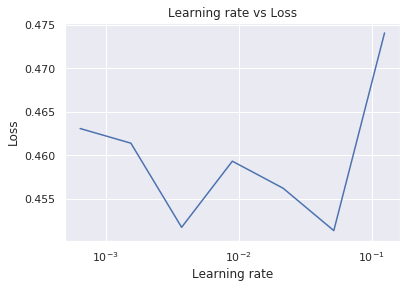

In [71]:
lr_finder.plot_lr()

In [72]:
model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['acc', keras.metrics.Recall()])

In [73]:
model.fit([X_train[cont_vars].values, X_train[cat_vars].values], y_train.astype('int').values,
          epochs=10, batch_size=128, callbacks=[OneCycleScheduler(1e-3, 2733, 128)],
          validation_data=[[X_valid[cont_vars].values, X_valid[cat_vars].values], y_valid.astype('int').values])

Train on 2733 samples, validate on 600 samples
Epoch 1/10
2733/2733 [==============================] - 2s 604us/sample - loss: 0.4035 - acc: 0.8434 - recall_10: 0.2045 - val_loss: 0.3375 - val_acc: 0.8633 - val_recall_10: 0.0575
Epoch 2/10
2733/2733 [==============================] - 0s 83us/sample - loss: 0.3037 - acc: 0.8975 - recall_10: 0.4672 - val_loss: 0.2616 - val_acc: 0.9033 - val_recall_10: 0.4598
Epoch 3/10
2733/2733 [==============================] - 0s 74us/sample - loss: 0.2764 - acc: 0.9067 - recall_10: 0.4874 - val_loss: 0.2627 - val_acc: 0.9050 - val_recall_10: 0.6207
Epoch 4/10
2733/2733 [==============================] - 0s 72us/sample - loss: 0.2441 - acc: 0.9140 - recall_10: 0.5202 - val_loss: 0.2041 - val_acc: 0.9167 - val_recall_10: 0.5747
Epoch 5/10
2733/2733 [==============================] - 0s 76us/sample - loss: 0.2355 - acc: 0.9173 - recall_10: 0.5884 - val_loss: 0.1867 - val_acc: 0.9250 - val_recall_10: 0.6207
Epoch 6/10
2733/2733 [=========================

In [74]:
model.optimizer.lr = 1e-5

In [75]:
model.fit([X_train[cont_vars].values, X_train[cat_vars].values], y_train.astype('int').values,
          epochs=5, batch_size=128,
          validation_data=[[X_valid[cont_vars].values, X_valid[cat_vars].values], y_valid.astype('int').values])

Train on 2733 samples, validate on 600 samples
Epoch 1/5
2733/2733 [==============================] - 0s 74us/sample - loss: 0.1740 - acc: 0.9455 - recall_10: 0.7146 - val_loss: 0.1602 - val_acc: 0.9467 - val_recall_10: 0.7471
Epoch 2/5
2733/2733 [==============================] - 0s 70us/sample - loss: 0.1741 - acc: 0.9451 - recall_10: 0.7273 - val_loss: 0.1601 - val_acc: 0.9433 - val_recall_10: 0.7241
Epoch 3/5
2733/2733 [==============================] - 0s 73us/sample - loss: 0.1695 - acc: 0.9473 - recall_10: 0.7222 - val_loss: 0.1605 - val_acc: 0.9417 - val_recall_10: 0.7241
Epoch 4/5
2733/2733 [==============================] - 0s 71us/sample - loss: 0.1721 - acc: 0.9469 - recall_10: 0.7045 - val_loss: 0.1602 - val_acc: 0.9483 - val_recall_10: 0.7586
Epoch 5/5
2733/2733 [==============================] - 0s 73us/sample - loss: 0.1710 - acc: 0.9466 - recall_10: 0.7045 - val_loss: 0.1612 - val_acc: 0.9450 - val_recall_10: 0.7586


In [83]:
lr_finder = LRFinder(2733, 128)

In [84]:
recall = keras.metrics.Recall()

In [85]:
md = ChurnModel(emb_size, [500, 250, 100], [0, 0 ,0])
md.compile(Adam(0.01), loss='binary_crossentropy', metrics=['acc', recall])

In [86]:
md.fit([X_train[cont_vars].values, X_train[cat_vars].values], y_train.astype('int').values,
          epochs=1, batch_size=128, callbacks=[lr_finder], class_weight={0:0.6, 1:3.3})

  ...
    to  
  ['...']
Train on 2733 samples
2733/2733 [==============================] - 2s 603us/sample - loss: 1.0374 - acc: 0.4460 - recall_15: 0.7500

LR finder is complete. Restoring initial model weights


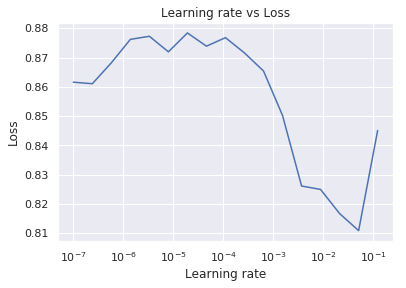

In [87]:
lr_finder.plot_lr(skip_start=0)

In [75]:
recall = keras.metrics.Recall()

In [88]:
md.compile(Adam(1e-3), loss='binary_crossentropy', metrics=['acc', keras.metrics.Recall()])
his = md.fit([X_train[cont_vars].values, X_train[cat_vars].values], y_train.astype('int').values,
          epochs=8, batch_size=128, callbacks=[OneCycleScheduler(1e-3, 2733, 128)],
          validation_data=[[X_valid[cont_vars].values, X_valid[cat_vars].values], y_valid.astype('int').values], 
          class_weight={0:1, 1:4})

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 2733 samples, validate on 600 samples
Epoch 1/8
2733/2733 [==============================] - 2s 847us/sample - loss: 1.2055 - acc: 0.3143 - recall_16: 0.9343 - val_loss: 0.9293 - val_acc: 0.3700 - val_recall_16: 0.9195
Epoch 2/8
2733/2733 [==============================] - 0s 89us/sample - loss: 0.8190 - acc: 0.6341 - recall_16: 0.8687 - val_loss: 0.7056 - val_acc: 0.7783 - val_recall_16: 0.7931
Epoch 3/8
2733/2733 [==============================] - 0s 87us/sample - loss: 0.6063 - acc: 0.8211 - recall_16: 0.8030 - val_loss: 0.5660 - val_acc: 0.8550 - val_recall_16: 0.8046
Epoch 4/8
2733/2733 [==============================] - 0s 86us/sample - loss: 0.4746 - acc: 0.8917 - recall_16: 0.8384 - val_loss: 0.5830 - val_acc: 0.8483 - val_recall_16: 0.8851
Epoch 5/8
2733/2733 [==============================] - 0s 90us/sample - loss: 0.4139 - acc: 0.9030 - recall_16: 0.8636 - val_loss: 0.4465 - val_acc: 0.9133 - val_recall_16: 0.8276
Ep

In [89]:
md.optimizer.lr = 1e-8

In [91]:
 md.fit([X_train[cont_vars].values, X_train[cat_vars].values], y_train.astype('int').values,
          epochs=3, batch_size=128, 
          validation_data=[[X_valid[cont_vars].values, X_valid[cat_vars].values], y_valid.astype('int').values], 
          class_weight={0:1, 1:4})

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 2733 samples, validate on 600 samples
Epoch 1/3
2733/2733 [==============================] - 0s 78us/sample - loss: 0.3093 - acc: 0.9363 - recall_16: 0.8914 - val_loss: 0.4189 - val_acc: 0.9183 - val_recall_16: 0.8621
Epoch 2/3
2733/2733 [==============================] - 0s 80us/sample - loss: 0.3161 - acc: 0.9360 - recall_16: 0.8838 - val_loss: 0.4189 - val_acc: 0.9133 - val_recall_16: 0.8506
Epoch 3/3
2733/2733 [==============================] - 0s 82us/sample - loss: 0.3045 - acc: 0.9396 - recall_16: 0.8813 - val_loss: 0.4195 - val_acc: 0.9083 - val_recall_16: 0.8506


In [116]:
md.evaluate([X_valid[cont_vars], X_valid[cat_vars]], y_valid)

600/600 [==============================] - 0s 501us/sample - loss: 0.2670 - acc: 0.9083 - recall_16: 0.8506


[0.26702941715717315, 0.90833336, 0.85057473]

# Oversampling

In [38]:
y_train = y_train.astype('int').values
y_valid = y_valid.astype('int').values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [45]:
pos = X_train[y_train==1]
pos_labels = y_train[y_train==1]
neg = X_train[y_train==0]
neg_labels = y_train[y_train==0]

In [46]:
def make_ds(X, y):
    X_cont = X[cont_vars].values
    X_cat = X[cat_vars].values
    ds = tf.data.Dataset.from_tensor_slices(((X_cont, X_cat), y))
    return ds
pos_ds  = make_ds(pos, pos_labels).shuffle(500).repeat()
neg_ds = make_ds(neg, neg_labels).shuffle(500).repeat()

In [47]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(128).prefetch(2)


In [48]:
valid_ds = make_ds(X_valid, y_valid).cache().batch(128).prefetch(2)

In [49]:
model = ChurnModel(emb_size, [500, 250, 100], [0, 0 ,0])
model.compile(Adam(1e-3), loss='binary_crossentropy', metrics=['acc', keras.metrics.Recall()])

In [50]:
model.fit(resampled_ds, steps_per_epoch=22, epochs=10, validation_data=valid_ds, callbacks=[OneCycleScheduler(1e-3, 2733, 128)])

Train for 22 steps, validate for 5 steps
Epoch 1/10
22/22 [==============================] - 2s 88ms/step - loss: 0.8965 - acc: 0.5767 - recall_2: 0.1645 - val_loss: 0.3193 - val_acc: 0.8583 - val_recall_2: 0.0230
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 0.5752 - acc: 0.7880 - recall_2: 0.6246 - val_loss: 0.2812 - val_acc: 0.8967 - val_recall_2: 0.5402
Epoch 3/10
22/22 [==============================] - 0s 12ms/step - loss: 0.4129 - acc: 0.8423 - recall_2: 0.7331 - val_loss: 0.2592 - val_acc: 0.9067 - val_recall_2: 0.6552
Epoch 4/10
22/22 [==============================] - 0s 12ms/step - loss: 0.3037 - acc: 0.8853 - recall_2: 0.8381 - val_loss: 0.2895 - val_acc: 0.8883 - val_recall_2: 0.8276
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 0.2551 - acc: 0.9066 - recall_2: 0.8757 - val_loss: 0.2232 - val_acc: 0.9250 - val_recall_2: 0.8276
Epoch 6/10
22/22 [==============================] - 0s 12ms/step - loss: 0.2150 - acc: 0.9162 